# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish.

In [1]:
import tensorflow as tf
from scipy.io import loadmat

# Additional libraries imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,\
 MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,\
ModelCheckpoint

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/My Drive/svhn_data/train_32x32.mat')
test = loadmat('/content/gdrive/My Drive/svhn_data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
# Extraction of train and test images  and labels
X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']

In [5]:
# Checking the shape of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


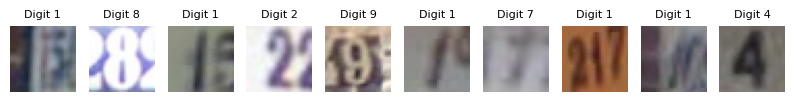

In [6]:
# Display random sample (10) of images
rng = np.random.default_rng()
indx = rng.choice(X_train.shape[3], size=10, replace = False)

img_sample =  X_train[..., indx]
label_sample = y_train[indx,]

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(len(indx)):
    axs[i].imshow(img_sample[...,i])
    axs[i].axis('off')
    axs[i].set_title(f'Digit {label_sample[i,].item()}', fontsize=8)
plt.show()

In [7]:
# Conversion to grayscale and verify shape change
X_train = np.mean(X_train, axis=2, keepdims=True)
X_test = np.mean(X_test, axis=2, keepdims=True)
print(X_train.shape)
print(X_test.shape)

(32, 32, 1, 73257)
(32, 32, 1, 26032)


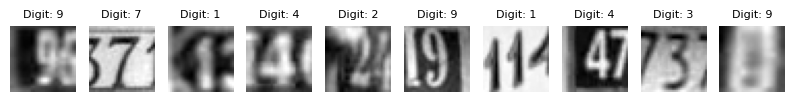

In [8]:
# Display random sample (10) of images aftergrayscale transformation
indx = rng.choice(X_train.shape[3], size=10, replace = False)

img_sample =  X_train[...,indx]
label_sample = y_train[indx,]

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(len(indx)):
    axs[i].imshow(np.squeeze(img_sample[...,i]), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Digit: {label_sample[i,].item()}', fontsize=8)
plt.show()

In [9]:
# Preprocessing of data in the format required
# by the layers (n_samples, height, width, channels)
X_train = X_train.transpose((3, 0, 1, 2))
X_test = X_test.transpose((3, 0, 1, 2))
print(X_train.shape)
print(X_test.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


In [10]:
# Scaling the values
X_train = X_train / 255
X_test = X_test / 255

In [11]:
# The number zero is codified a 10 in the labels datasets, setting
# it to 0 for compatibility with the neural network models
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
# Building MLP model
def get_model_mlp(input_shape):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(Flatten(name='Flatten'))
  model.add(Dense(256, activation='relu', name='Dense_1'))
  model.add(Dense(512, activation='relu', name='Dense_2'))
  model.add(Dense(128, activation='relu', name='Dense_3'))
  model.add(Dense(10, activation='softmax', name='Output'))
  return model

In [13]:
#Summary of the MLP model

model_mlp = get_model_mlp(X_train[0].shape)
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 460,938 (1.76 MB)

 Trainable params: 460,938 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compilation of MLP model
model_mlp.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
# First callback definition (EarlyStopping)
early_stopping = EarlyStopping(patience = 10,
                               monitor='val_accuracy',
                               mode='max',
                               verbose=1)

In [16]:
# Second callback definition (RedunceLROPlateau)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=5, verbose=1,
                              mode='max', min_delta=0.01,
                              cooldown=0, min_lr=1e-6)

In [17]:
# Third callback (ModelCheckpoint) defined through a helper function
# to be reutilized for the CNN netword
def ckp_best(ckp_best_path):
  checkpoint_best = ModelCheckpoint(filepath=ckp_best_path,
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_freq='epoch',
                             save_weights_only=True,
                             verbose=1)
  return checkpoint_best

In [18]:
# Set the directory to save the best MLP weights
ckp_mlp_best_path = "/content/gdrive/My Drive/ckps_best/mlp_best.weights.h5"
checkpoint_best = ckp_best(ckp_mlp_best_path)

In [19]:
%%time
# Training of MLP model
history_mlp = model_mlp.fit(X_train, y_train,
                            epochs=30,
                            validation_split=0.15,
                            batch_size=32,
                            callbacks=[early_stopping, reduce_lr, checkpoint_best])

Epoch 1/30
1945/1946 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1957 - loss: 2.2245
Epoch 1: val_accuracy improved from -inf to 0.30512, saving model to /content/gdrive/My Drive/ckps_best/mlp_best.weights.h5
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.1957 - loss: 2.2245 - val_accuracy: 0.3051 - val_loss: 2.0320 - learning_rate: 0.0100
Epoch 2/30
1935/1946 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3813 - loss: 1.8631
Epoch 2: val_accuracy improved from 0.30512 to 0.42606, saving model to /content/gdrive/My Drive/ckps_best/mlp_best.weights.h5
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.3817 - loss: 1.8622 - val_accuracy: 0.4261 - val_loss: 1.6728 - learning_rate: 0.0100
Epoch 3/30
1943/1946 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5470 - loss: 1.4032
Epoch 3: val_accuracy improved from 0.42606 to 0.55028, saving model to /content/gdrive/My Drive/ckps_best/mlp_best.weights.h5
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5471 - loss:

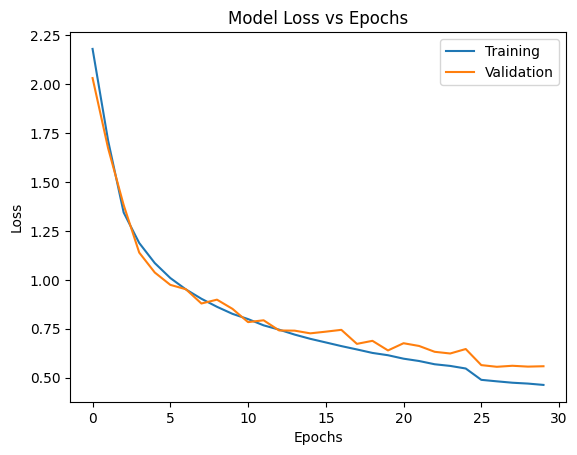

In [20]:
# Plot of Model Loss vs Epochs (Training and Validation)

plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Model Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

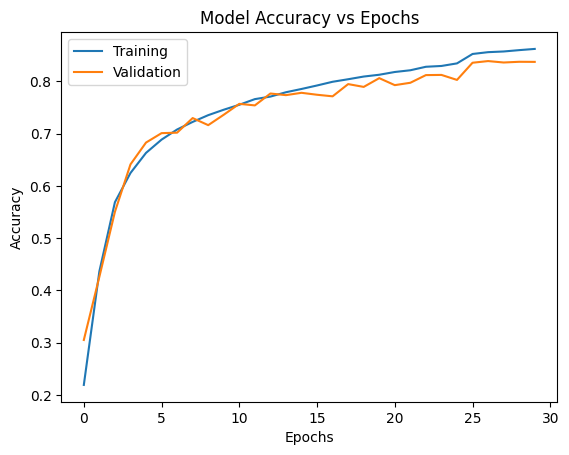

In [21]:
# Plot of Model Accuracy vs Epochs (Training and Validation)

plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Model Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [22]:
# Evaluation of trained MLP model on test set

test_loss, test_acc = model_mlp.evaluate(X_test, y_test, verbose=0)
print('Test loss: {loss:0.3f}\nTest accuracy: {acc:0.2f}%'.\
      format(loss=test_loss, acc=100*test_acc))

Test loss: 0.651
Test accuracy: 81.75%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [23]:
# Building CNN model
def get_model_cnn(input_shape):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(Conv2D(16, (2,2), activation='relu',padding='same', name='Conv_1'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), name='Pool_1'))
  model.add(Dropout(0.2, name='Dropout_1'))
  model.add(Conv2D(16, (2,2), activation='relu',padding='same', name='Conv_2'))
  model.add(MaxPooling2D((2,2), name='Pool_2'))
  model.add(Flatten(name='Flatten_1'))
  model.add(Dropout(0.2, name='Dropout_2'))
  model.add(Dense(64, activation='relu', name='Dense_1'))
  model.add(Dense(10, activation='softmax', name='Output'))
  return model

In [24]:
#Summary of the CNN model

model_cnn = get_model_cnn(X_train[0].shape)
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                      │ (None, 32, 32, 16)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool_1 (MaxPooling2D)                │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv2D)                      │ (None, 16, 16, 16)          │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool_2 (MaxPooling2D)                │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,434 (263.41 KB)

 Trainable params: 67,402 (263.29 KB)

 Non-trainable params: 32 (128.00 B)

In [25]:
# Compilation of CNN model

model_cnn.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [26]:
# Set the directory to save the best CNN weights
ckp_cnn_best_path = "/content/gdrive/My Drive/svhn/ckps_best/cnn_best.weights.h5"
checkpoint_best = ckp_best(ckp_cnn_best_path)

In [27]:
%%time
# Training of CNN model
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=30,
                            validation_split=0.15,
                            batch_size=32,
                            callbacks=[early_stopping,
                                       reduce_lr,
                                       checkpoint_best])

Epoch 1/30
1945/1946 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2011 - loss: 2.2095
Epoch 1: val_accuracy improved from -inf to 0.51379, saving model to /content/gdrive/My Drive/svhn/ckps_best/cnn_best.weights.h5
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 59s 30ms/step - accuracy: 0.2012 - loss: 2.2093 - val_accuracy: 0.5138 - val_loss: 1.5442 - learning_rate: 0.0100
Epoch 2/30
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5168 - loss: 1.4535
Epoch 2: val_accuracy improved from 0.51379 to 0.62717, saving model to /content/gdrive/My Drive/svhn/ckps_best/cnn_best.weights.h5
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.5168 - loss: 1.4534 - val_accuracy: 0.6272 - val_loss: 1.1292 - learning_rate: 0.0100
Epoch 3/30
1945/1946 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7037 - loss: 0.9409
Epoch 3: val_accuracy improved from 0.62717 to 0.80317, saving model to /content/gdrive/My Drive/svhn/ckps_best/cnn_best.weights.h5
1946/1946 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - acc

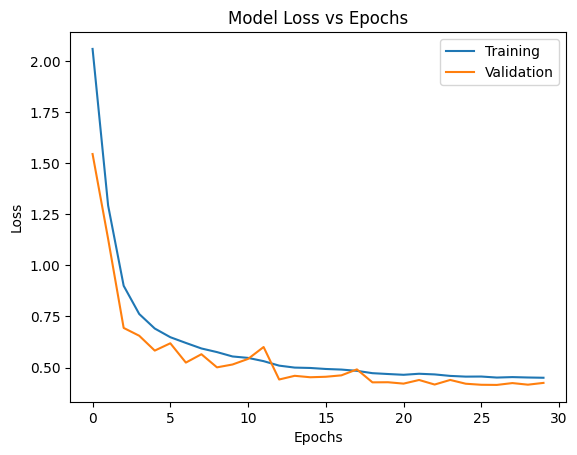

In [28]:
# Plot of Model Loss vs Epochs (Training and Validation)

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

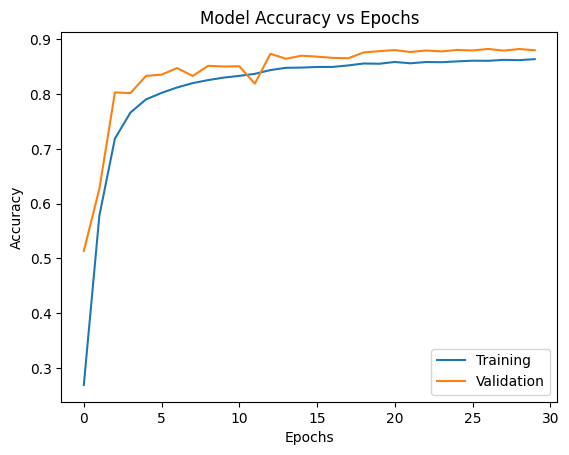

In [29]:
# Plot of Model Accuracy vs Epochs (Training and Validation)

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [30]:
# Evaluation of trained CNN model on test set

test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=0)
print('Test loss: {loss:0.3f}\nTest accuracy: {acc:0.2f}%'.\
      format(loss=test_loss, acc=100*test_acc))

Test loss: 0.483
Test accuracy: 86.27%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [31]:
# Loading best weights of MLP
model_mlp_new = get_model_mlp(X_train[0].shape)
model_mlp.load_weights(ckp_mlp_best_path)

In [32]:
# Loading best weights of CNN
model_cnn_new = get_model_cnn(X_train[0].shape)
model_cnn_new.load_weights(ckp_cnn_best_path)

In [33]:
# Selecting 5 random images
random_index = rng.choice(X_test.shape[0], size=5, replace = False)
random_test_image = X_test[random_index]
random_test_label = y_test[random_index]

In [34]:
# Calculate predictions for random images
predictions_mlp = model_mlp_new.predict(random_test_image, verbose=0)
predictions_cnn = model_cnn_new.predict(random_test_image, verbose=0)

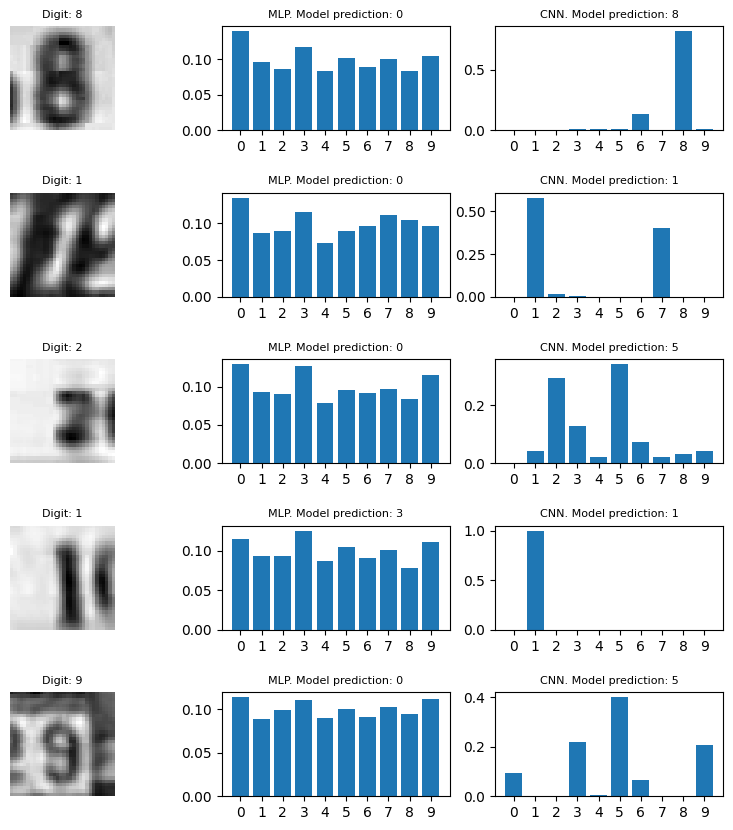

In [35]:
# Plotting the randomimages with labels, and the
# distributions of the predictions
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6, wspace= 0.2)
for i in range(len(random_index)):
    axs[i,0].imshow(random_test_image[i], cmap='gray')
    axs[i,0].axis('off')
    axs[i,0].set_title(f'Digit: {random_test_label[i].item()}', fontsize=8)
    axs[i,1].bar(np.arange(10), predictions_mlp[i])
    axs[i,1].set_title(f"MLP. Model prediction: {np.argmax(predictions_mlp[i])}",
                       fontsize=8)
    axs[i,1].set_xticks(np.arange(10))
    axs[i,2].bar(np.arange(10), predictions_cnn[i])
    axs[i,2].set_title(f"CNN. Model prediction: {np.argmax(predictions_cnn[i])}",
                       fontsize=8)
    axs[i,2].set_xticks(np.arange(10))
plt.show()